## Dependencies

In [9]:
from BNReasoner import BNReasoner
import pandas as pd
import numpy as np
from copy import deepcopy

## Test implementation

### Test | `Network Pruning`

Before pruning...


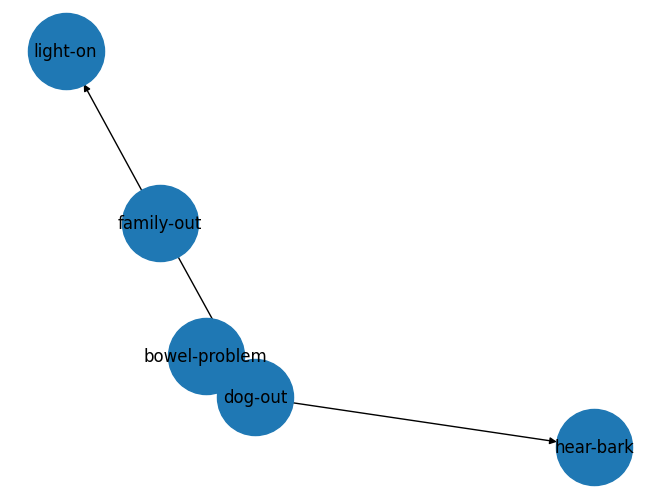

After pruning...


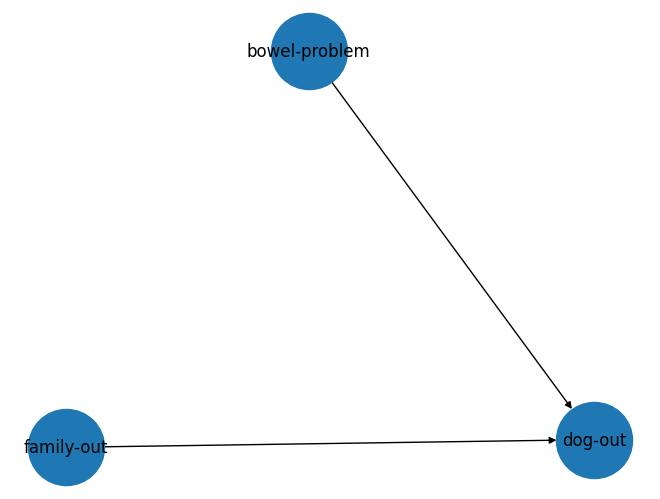

In [10]:
# Init
dog_problem = BNReasoner("testing/dog_problem.BIFXML")

print("Before pruning...")
dog_problem.draw()

# Prune
dog_problem.prune(Q = {"dog-out", "bowel-problem"}, e = set())

print("After pruning...")
dog_problem.draw()

### Test | `D separation`

In [11]:
dog_problem = BNReasoner("testing/dog_problem.BIFXML")

assert dog_problem.d_separated(X = {"dog-out"}, Y = {"bowel-problem"}, Z = set())

### Test | `Maxing out variables`

In [12]:
"""
: BN course 4 -> pag. 11
:return:
"""
initial = pd.DataFrame(columns=["B", "C", "D", "f1"], data=np.array([
    [True, True, True, 0.95],
    [True, True, False, 0.05],
    [True, False, True, 0.90],
    [True, False, False, 0.10],
    [False, True, True, 0.80],
    [False, True, False, 0.20],
    [False, False, True, 0.00],
    [False, False, False, 1.00],
]))

expected = pd.DataFrame(columns=["B", "C", "max_D > f1"], data=np.array([
    [True, True, 0.95],
    [True, False, 0.9],
    [False, True, 0.8],
    [False, False, 1],
]))

actual = BNReasoner.maxing_out("D", initial)
assert actual.equals(expected) is True

### Test | `Summing out variables`

In [13]:
"""
: BN course 4 -> pag. 11
:return:
"""
initial = pd.DataFrame(columns=["B", "C", "D", "f1"], data=np.array([
    [True, True, True, 0.95],
    [True, True, False, 0.05],
    [True, False, True, 0.90],
    [True, False, False, 0.10],
    [False, True, True, 0.80],
    [False, True, False, 0.20],
    [False, False, True, 0.00],
    [False, False, False, 1.00],
]))

expected = pd.DataFrame(columns=["B", "C", "sum_D > f1"], data=np.array([
    [True, True, 1.0],
    [True, False, 1.0],
    [False, True, 1.0],
    [False, False, 1.0],
]))

actual = BNReasoner.marginalization("D", initial)
assert actual.equals(expected) is True

### Test | `Factor multiplication`